# Multivariate Forecasting with NBEATS

This notebook outlines the application of NBEATS, a recently-proposed model for time series forecasting, to a Electricity Consumption Dataset. The dataset contains the hourly electricity consumption of 321 customers from 2012 to 2014.

This demo uses an implementation of NBEATS from the PyTorch Forecasting package. [PyTorch Forecasting](https://github.com/jdb78/pytorch-forecasting) is a package/repository that provides convenient implementations of several leading deep learning-based forecasting models, namely [Temporal Fusion Transformers](https://arxiv.org/pdf/1912.09363.pdf), [N-BEATS](http://arxiv.org/abs/1905.10437), and [DeepAR](https://www.sciencedirect.com/science/article/pii/S0169207019301888). PyTorch Forecasting is built using [PyTorch Lightning](https://pytorch-lightning.readthedocs.io/), making it easier to train in multi-GPU compute environments, out-of-the-box. 

## Package Imports and Global Variables



**Note for Colab users:** Run the following cell to install PyTorch Forecasting. After installation completes, you will likely need to restart the Colab runtime. If this is the case, a button `RESTART RUNTIME` will appear at the bottom of the next cell's output.

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install pytorch-forecasting

In [3]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import torch
import pytorch_lightning as pl
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_forecasting.metrics import NormalDistributionLoss
from pytorch_forecasting import TimeSeriesDataSet, Baseline, NBeats, GroupNormalizer, MultiNormalizer, EncoderNormalizer

In [4]:
DATA_PATH = "../datasets/electricity/electricity.csv"

EPOCHS = 1
VAL_PERC = .1
TEST_PERC = .005
BATCH_SIZE = 32

LAG_TIME = 30
LEAD_TIME = 30

## Load Data
We start by loading the data from a CSV file from `DATA_PATH` into a dataframe. Each column of the dataframe is a different time series that measures the hourly electricity consumption of one of the 320 households included in the dataset. Additonally, there is also a column that encodes the date and time of the observations. The last column, `OT`, is dropped as it is not relevant for this demo. 

In [5]:
df = pd.read_csv(DATA_PATH, index_col=0)
df = df.iloc[:, :-1]
df.index = pd.to_datetime(df.index)
df = df.reset_index().rename({'index':'date'}, axis=1)
df

,date,0,1,2,3,4,5,6,7,8,...,310,311,312,313,314,315,316,317,318,319
0,2016-07-01 02:00:00,14.0,69.0,234.0,415.0,215.0,1056.0,29.0,840.0,226.0,...,199.0,676.0,372.0,80100.0,4719.0,5002.0,48.0,38.0,1558.0,182.0
1,2016-07-01 03:00:00,18.0,92.0,312.0,556.0,292.0,1363.0,29.0,1102.0,271.0,...,265.0,805.0,452.0,95200.0,4643.0,6617.0,65.0,47.0,2177.0,253.0
2,2016-07-01 04:00:00,21.0,96.0,312.0,560.0,272.0,1240.0,29.0,1025.0,270.0,...,278.0,817.0,430.0,96600.0,4285.0,6571.0,64.0,43.0,2193.0,218.0
3,2016-07-01 05:00:00,20.0,92.0,312.0,443.0,213.0,845.0,24.0,833.0,179.0,...,271.0,801.0,291.0,94500.0,4222.0,6365.0,65.0,39.0,1315.0,195.0
4,2016-07-01 06:00:00,22.0,91.0,312.0,346.0,190.0,647.0,16.0,733.0,186.0,...,267.0,807.0,279.0,91300.0,4116.0,6298.0,75.0,40.0,1378.0,191.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26299,2019-07-01 21:00:00,11.0,116.0,8.0,844.0,384.0,1590.0,51.0,1412.0,407.0,...,178.0,1897.0,1589.0,166500.0,9917.0,10412.0,324.0,21.0,1870.0,162.0
26300,2019-07-01 22:00:00,11.0,103.0,8.0,749.0,371.0,1366.0,47.0,1265.0,369.0,...,241.0,1374.0,1336.0,158800.0,6812.0,8956.0,302.0,20.0,1506.0,438.0
26301,2019-07-01 23:00:00,12.0,93.0,8.0,650.0,346.0,1282.0,48.0,1079.0,308.0,...,158.0,938.0,1311.0,154300.0,6602.0,5910.0,302.0,18.0,1864.0,621.0
26302,2019-07-02 00:00:00,10.0,92.0,8.0,646.0,349.0,1261.0,48.0,1009.0,288.0,...,120.0,833.0,1227.0,141900.0,6546.0,5502.0,259.0,33.0,2623.0,783.0


### Data Splitting
The data is split sequentially into train, validation and test based on `VAL_PERC` and `TEST_PERC` global variables. We will withhold the last `TEST_PERC` of data for testing. In the code below, we are very careful to ensure that when training and validating the model, it does not have access to the withheld data.

In [6]:
n_samples = len(df)
n_val = int(n_samples * VAL_PERC)
n_test = int(n_samples * TEST_PERC)
n_train = n_samples - (n_val + n_test)

# Split data into train and test
train_df = df.iloc[:n_train, :]
val_df = df.iloc[n_train:n_train+n_val]
test_df = df.iloc[n_train+n_val:]



## Data Formatting

PyTorch Forecasting expects data to be formatted using its own [TimeSeriesDataSet](https://pytorch-forecasting.readthedocs.io/en/latest/data.html) objects. Building a TimeSeriesDataSet begins with a Pandas DataFrame that we need to add certain custom columns. 

PyTorch Forecasting models can accomodate datasets consisting of multiple, coincident time series in several ways. As per the [documentation](https://pytorch-forecasting.readthedocs.io/en/latest/data.html), a combination of `group_id` and `time_idx` identify a sample in the data, and that *if we have only one time series, to set* `group_id` *to a constant.* `time_idx` is an *integer column denoting the time index*. This, as opposed to the `date` column, is used to determine the temporal sequence of samples. 

In [7]:
# Rename index to time_idx
train_df = train_df.reset_index().rename({'index':'time_idx'}, axis=1)
val_df = val_df.reset_index().rename({'index':'time_idx'}, axis=1)
test_df = test_df.reset_index().rename({'index':'time_idx'}, axis=1)

train_df['group_ids'] = 0
val_df['group_ids'] = 0
test_df['group_ids'] = 0

In [8]:
# Reshape data into single value column that is uniquely indexed by pairs of (time_idx, group_ids).
train_df = train_df.melt(id_vars=['time_idx', 'date'], value_vars=df.columns, var_name='group_ids')
val_df = val_df.melt(id_vars=['time_idx', 'date'], value_vars=df.columns, var_name='group_ids')
test_df = test_df.melt(id_vars=['time_idx', 'date'], value_vars=df.columns, var_name='group_ids')

## Dataset Definition
Now that we have the data in the format that TimeSeriesDataset expects, we can define the `train_dataset`, `val_dataset` and `test_dataset`. For each dataset, we can pass a number of parameters that specify the characteristics of the data and how it should be processed prior to being fed to the model. Some of the arguments include: 
- `data`: (pd.DataFrame) – dataframe with sequence data - each row can be identified with `time_idx` and the `group_ids`
- `target`: (Union[str, List[str]]) – column denoting the target or list of columns denoting the target - categorical or continous.
- `max_encoder_length`: (int) – maximum length to encode. This is the maximum history length used by the time series dataset.
- `max_prediction_length`: (int) – maximum prediction/decoder length (choose this not too short as it can help convergence)

For additional details in regards to the `TimeSeriesDataset` class, consult the  [PyTorch Forecasting Documentation](https://pytorch-forecasting.readthedocs.io/en/stable/api/pytorch_forecasting.data.timeseries.TimeSeriesDataSet.html).

In [9]:
# Define datasets
train_data = TimeSeriesDataSet(
    data=train_df,  
    time_idx="time_idx",
    target="value",
    categorical_encoders={"group_ids": NaNLabelEncoder().fit(train_df.group_ids)},
    group_ids=['group_ids'],
    max_encoder_length=LAG_TIME,
    max_prediction_length=LEAD_TIME,
    time_varying_unknown_reals=["value"],
)

val_data = TimeSeriesDataSet(
    data=val_df,  
    time_idx="time_idx",
    target="value",
    categorical_encoders={"group_ids": NaNLabelEncoder().fit(val_df.group_ids)},
    group_ids=['group_ids'],
    max_encoder_length=LAG_TIME,
    max_prediction_length=LEAD_TIME,
    time_varying_unknown_reals=["value"],
)

test_data = TimeSeriesDataSet(
    data=test_df,  
    time_idx="time_idx",
    target="value",
    categorical_encoders={"group_ids": NaNLabelEncoder().fit(test_df.group_ids)},
    group_ids=['group_ids'],
    max_encoder_length=LAG_TIME,
    max_prediction_length=LEAD_TIME,
    time_varying_unknown_reals=["value"],
)

/h/jewtay/.conda/envs/pyfor/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:618: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/h/jewtay/.conda/envs/pyfor/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:618: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


In [10]:
# Define dataloader
train_dataloader = train_data.to_dataloader(train=True, batch_size=BATCH_SIZE, num_workers=4)
val_dataloader = val_data.to_dataloader(train=False, batch_size=BATCH_SIZE, num_workers=4)
test_dataloader = test_data.to_dataloader(train=False, batch_size=BATCH_SIZE, num_workers=4)

## Model

### NBEATS Overview

<p align="center">
<img width="430" alt="Screen Shot 2022-01-25 at 6 19 35 PM" src="https://user-images.githubusercontent.com/34798787/155443902-04fd5960-dd90-4198-be6f-047ac35fa26b.png">
</p>

NBEATS is a popular deep learning based approach to time series forecasting. NBEATS learns a global model from historical data of one or more time series. Thus, although the input and output space is univariate, NBEATS can be used to jointly model a set of related time series. The architecture consists of deep stacks of fully connected layers connected with forward and backward residual links. The forwad links aggregate partial forecast to yield final forecast. Alternatively, backward links subtract out input signal corresponding to already predicted partial forecast from input prior to being passed to the next stack. Some additional features of NBEATS include: 
- **Interpretability**: Allows for hierarchical decomposition of a forecasts into trend and seasonal components which enhances interpretability. 
- **Ensembling**: Ensembles models fit with different loss functions and time horizons. The final prediction is mean of models in ensemble. 
- **Efficient**: Avoids the use of recurrent structute and predicts entire ouput sequence in single forward pass.

## Model Definition
Using the Pytorch Forecasting package, an NBEATS model can easily be initialized using the `NBeats.from_dataset` method. This method constructs a NBEATS model using the characteristics of the TimeSeriesDataset that it is operating on. The arguments of the method include: 
- `dataset`: (TimeSeriesDataset) time series dataset
- `learning_rate`: (float) The learning rate of the optimization procedure. 
- `weight_decay`: (float) The weight decay that is applied to the model parameters. 

For additional details in regards to the `NBeats` class, consult the  [PyTorch Forecasting Documentation](https://pytorch-forecasting.readthedocs.io/en/stable/api/pytorch_forecasting.models.nbeats.NBeats.html).

In [11]:
# Init model with structure specified in dataset
net = NBeats.from_dataset(
    train_data,
    learning_rate=1e-4,
    weight_decay=1e-2
)

/h/jewtay/.conda/envs/pyfor/lib/python3.9/site-packages/pytorch_forecasting/models/nbeats/sub_modules.py:154: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  coefficients = torch.tensor([backcast_linspace ** i for i in range(thetas_dim)], dtype=torch.float32)


## Training and Validation
We first define a pytorch lighting trainer which encapsulates the training process and allows us to easily implement a training and validation loop with the specified parameters. The arguments to the trainer include: 
- `max_epochs`: (Optional[int]) – Stop training once this number of epochs is reached. 
- `limit_train_batches`: (Union[int, float]) – How much of training dataset to check (float = fraction, int = num_batches).
- `limit_val_batches`: (Union[int, float]) – How much of validation dataset to check (float = fraction, int = num_batches).
- `callbacks`: (Union[List[Callback], Callback, None]) – Add a callback or list of callbacks.

Subsequently, we can use the `fit` method of the trainer with the `net`, `train_dataloader` and `val_dataloader` to perform the training and validation loop. 

For more information regarding the `pl.Trainer` class, consult the [PyTorch Lightning documentation](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.html#pytorch_lightning.trainer.trainer.Trainer.validate).

In [12]:
# Set random seed 
pl.seed_everything(42)

# Define early stopping criteria
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")

# Init pytorch lightning trainer
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    gpus=1,
    weights_summary="top",
    callbacks=[early_stop_callback],
    limit_train_batches=.2,
    limit_val_batches=.2,
)


# Train and Validate Model
trainer.fit(
    net,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader
)

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/h/jewtay/.conda/envs/pyfor/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:735: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.7 M 
-----------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.717     Total estimated model params size (MB)


/h/jewtay/.conda/envs/pyfor/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
Global seed set to 42


Epoch 0:   0%|          | 0/52110 [00:00<?, ?it/s] 

/h/jewtay/.conda/envs/pyfor/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/h/jewtay/.conda/envs/pyfor/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 0:   0%|          | 33/52110 [00:02<1:16:55, 11.28it/s, loss=3.09, v_num=6317167, train_loss_step=2.870]

/h/jewtay/.conda/envs/pyfor/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 0:   0%|          | 58/52110 [00:03<57:17, 15.14it/s, loss=2.75, v_num=6317167, train_loss_step=2.400]  

/h/jewtay/.conda/envs/pyfor/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 0:  90%|█████████ | 46968/52110 [29:22<03:12, 26.66it/s, loss=1.09, v_num=6317167, train_loss_step=0.828] 
Validating: 0it [00:00, ?it/s]
Validating:  15%|█▍        | 756/5142 [00:17<01:35, 45.71it/s]


Validating:  29%|██▉       | 1512/5142 [00:36<01:30, 39.95it/s]


Epoch 0:  95%|█████████▍| 49248/52110 [30:17<01:45, 27.10it/s, loss=1.09, v_num=6317167, train_loss_step=0.828]


Epoch 0:  96%|█████████▌| 50016/52110 [30:35<01:16, 27.24it/s, loss=1.09, v_num=6317167, train_loss_step=0.828]


Epoch 0:  97%|█████████▋| 50796/52110 [30:54<00:47, 27.39it/s, loss=1.09, v_num=6317167, train_loss_step=0.828]


Epoch 0:  99%|█████████▉| 51564/52110 [31:12<00:19, 27.54it/s, loss=1.09, v_num=6317167, train_loss_step=0.828]


Epoch 0: 100%|██████████| 52110/52110 [31:27<00:00, 27.61it/s, loss=1.09, v_num=6317167, train_loss_step=0.828, val_loss=1.540, train_loss_epoch=1.120]


In [13]:
# Load best model from checkpoint
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)

## Test

## Visualize Predictions

With the trained model from the previous step, we can apply it to the test set to get an unbias estimate of the models performance. Additionally, we can visualize the results to build some intuition about the forecasts being generated.

In [14]:
# Get predictions from test dataset
preds = best_model.predict(test_dataloader)

# Aggregate inputs, ground truth and classes into tensor alligned with predictions
input_list, true_list, class_list = [], [], []
for x, y in test_dataloader: 
    input_list.append(x["encoder_target"])
    true_list.append(y[0])
    class_list.append(x["groups"])


inputs = torch.cat(input_list)
trues = torch.cat(true_list)
classes = torch.cat(class_list)

print(inputs.shape, preds.shape, trues.shape, classes.shape)

/h/jewtay/.conda/envs/pyfor/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/h/jewtay/.conda/envs/pyfor/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/h/jewtay/.conda/envs/pyfor/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/h/jewtay/.conda/envs/pyfor/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/h/jewtay/.conda/envs/pyfor/lib/pyth

torch.Size([23040, 30]) torch.Size([23040, 30]) torch.Size([23040, 30]) torch.Size([23040, 1])


In [15]:
# Select indices of samples to visualize
n_samples = 10
ss_indices = np.random.choice(range(preds.shape[0]), n_samples, replace=False)
ss_pred = preds[ss_indices]
ss_true = trues[ss_indices]
ss_input = inputs[ss_indices]
ss_class = classes[ss_indices]

print(ss_input.shape, ss_pred.shape, ss_true.shape, ss_class.shape)

torch.Size([10, 30]) torch.Size([10, 30]) torch.Size([10, 30]) torch.Size([10, 1])


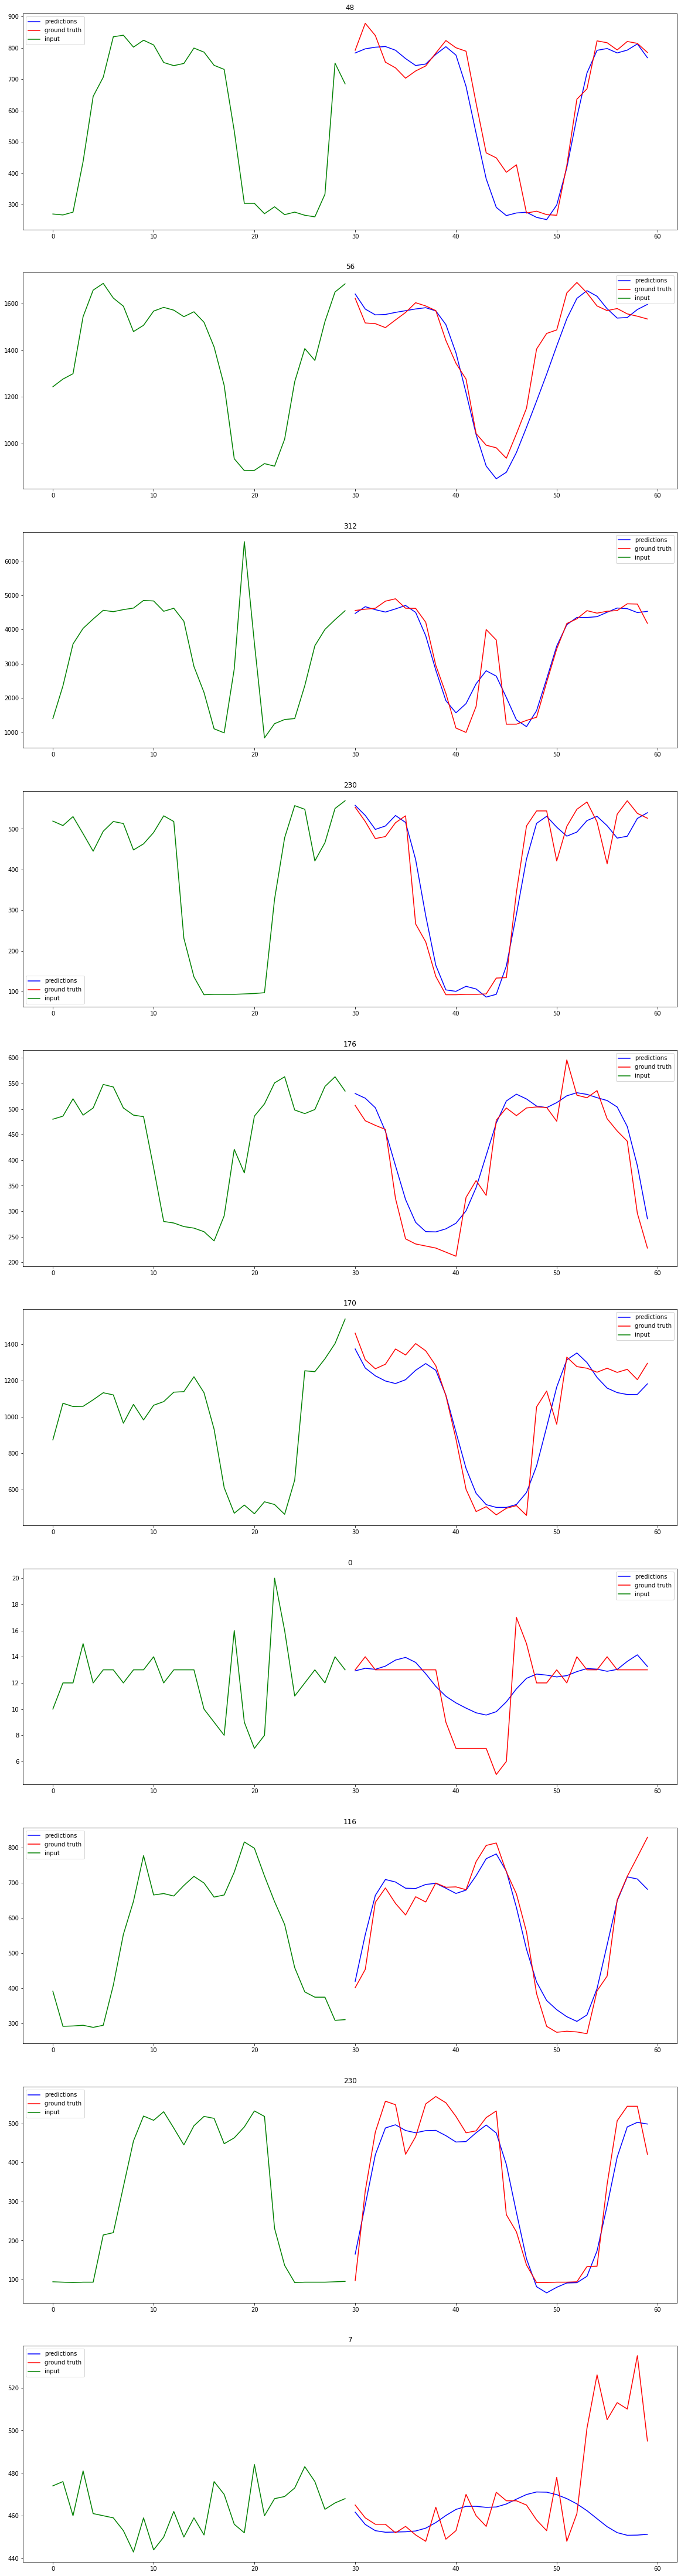

In [16]:
# Loop through samples and plot input, ground truth and prediction
f, axarr = plt.subplots(n_samples, 1, figsize=(20, 80))
for i in range(n_samples):
    series_preds = ss_pred[i, :].squeeze()
    series_trues = ss_true[i, :].squeeze()
    series_inputs = ss_input[i, :].squeeze()

    feat_name = str(ss_class[i].item())
    
    input_len = series_inputs.shape[0]
    pred_gt_len = series_preds.shape[0]
    input_x = np.array([i for i in range(input_len)])
    x = np.array([i for i in range(input_len, input_len+pred_gt_len)])
    axarr[i].plot(x, series_preds, c="blue", label="predictions")
    axarr[i].plot(x, series_trues, c="red", label="ground truth")
    axarr[i].plot(input_x, series_inputs, c="green", label="input")
    axarr[i].legend()
    axarr[i].set_title(feat_name)

### Quantitative Resutls
To assess the performance of NBEATS on the dataset, we calculate its performance on the test set using a set of metrics that are commonly used in time series forecasting. The metrics include Mean Absolute Error (MAE) and Mean Squared Error (MSE).

In [17]:
# Calculate losses
mse = mean_squared_error(trues.cpu().numpy(), preds.cpu().numpy())
mae = mean_absolute_error(trues.cpu().numpy(), preds.cpu().numpy())

print(f"MSE: {mse} MAE: {mae}")

MSE: 832445.3125 MAE: 181.22267150878906
